In [1]:
import re
import numpy as np
import pandas as pd
from scipy import sparse
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from wordcloud import WordCloud

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.base import BaseEstimator

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import log_loss, confusion_matrix

from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, SelectPercentile

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# the docker container is too small to run the gridsearch
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


## read data

In [197]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [198]:
classes = [x for x in train.columns if x not in ['id', 'comment_text']]

In [199]:
test.fillna(' ', inplace=True)
train.fillna(' ', inplace=True)

corr between different labels

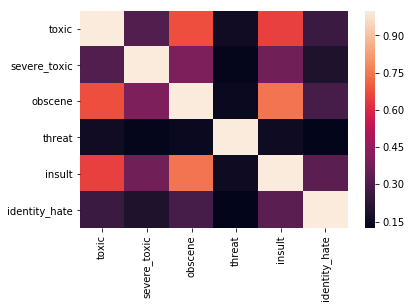

In [8]:
sns.heatmap(train[classes].corr())

## functions and classes

In [157]:
class standardize_text():
    def __init__(self):
        return
    
    def replace_entities(self, col):
        col = col.replace(r'\[WIKI_LINK\:\s[^\]]+\]', 'wikilink', regex=True)
        col = col.replace(r'\[EXTERNA_LINK\:\s[^\]]+\]', 'externalink', regex=True)
        col = col.replace(r'(https?\:\/\/|www)[^\s]+wikipedia[^\s]+', 'wikilink', regex=True)
        col = col.replace(r'(https?\:\/\/|www)[^\s]+[^wikipedia][^\s]+', 'externalink', regex=True)
        
        return col
    
    def clean(self, col):
        col = col.str.lower()
        col = col.replace(r'\n', ' ').replace(r'\t', ' ')
        col = col.replace(r'[^a-z\s]', '', regex=True)
        col = col.replace(r'\s+', ' ', regex=True)
        col = col.replace(r"([a-z]+?)\1+", r"\1\1", regex=True) # removes any repetitions of letters more than twice
        col = col.replace(r"\b(\w+)(\s)(\1\2?)+", r"\1", regex=True) # removes any repetitions of words more than once
        col = col.str.strip()
        
        return col

In [181]:
class create_count_features(BaseEstimator):
    def __init__(self):
        with open("../../External Data/badwords.txt") as f:
            badwords = [l.strip() for l in f.readlines()]
        self.badwords_ = badwords
        
    def fit(self, documents, y=None):
        return self

    def transform(self, documents):
        ## some handcrafted features!
        n_words = [len(c.split()) for c in documents]
        n_chars = [len(c) for c in documents]
        # number of uppercase words
        allcaps = [np.sum([w.isupper() for w in comment.split()])
               for comment in documents]
        # longest word
        max_word_len = [np.max([len(w) for w in c.split()]) for c in documents]
        # average word length
        mean_word_len = [np.mean([len(w) for w in c.split()])
                                            for c in documents]
        # number of google badwords:
        n_bad = [np.sum([c.lower().count(w) for w in self.badwords_])
                                                for c in documents]
        exclamation = [c.count("!") for c in documents]
        question = [c.count("?") for c in documents]
        newlines = [c.count("\n") for c in documents]
        tabs = [c.count("\t") for c in documents]
        wikilink = [c.count("wikilink") for c in documents]
        extralink = [c.count("externalink") for c in documents]
        spaces = [c.count(" ") for c in documents]

        allcaps_ratio = np.array(allcaps) / np.array(n_words, dtype=np.float)
        bad_ratio = np.array(n_bad) / np.array(n_words, dtype=np.float)

        return np.array([n_words, 
                         n_chars, 
                         allcaps, 
                         max_word_len,
                         mean_word_len, 
                         exclamation, 
                         question, 
                         tabs,
                         newlines,
                         wikilink, 
                         extralink, 
                         spaces, 
                         bad_ratio, 
                         n_bad, 
                         allcaps_ratio]).T
    
    def get_feature_names(self):
        return ['n_words', 
                 'n_chars', 
                 'allcaps', 
                 'max_word_len',
                 'mean_word_len', 
                 'exclamation', 
                 'question', 
                 'tabs',
                 'newlines',
                 'wikilink', 
                 'extralink', 
                 'spaces', 
                 'bad_ratio', 
                 'n_bad', 
                 'allcaps_ratio']

In [11]:
def train_best_model(pipe, parameters, X_train, y_train, X_val, y_val):
    predictions = pd.DataFrame()
    models = {}
    loss = 0
    for toxicity in classes:
        print(toxicity)
        est = GridSearchCV(pipe, 
                           parameters, 
                           scoring='neg_log_loss', 
                           n_jobs=-1,
                           cv=3, 
                           verbose=1)
        est.fit(X_train, y_train[toxicity])
        print(est.best_params_)
        print(est.best_score_)
        
        predictions[toxicity] = est.best_estimator_.predict_proba(X_val)[:, 1]
        models[toxicity] = est.best_estimator_
        
        ll = log_loss(y_val[toxicity], predictions[toxicity])
        print('>>> test log-loss: %s' % str(ll.round(3)))
        loss = loss + ll
        
    print('DONE! test mean log-loss: %s' % str(loss/6.))
    return predictions, models

## prepping features

In [158]:
st = standardize_text()

In [204]:
train['comment_text_clean'] = st.clean(st.replace_entities(train['comment_text']))
test['comment_text_clean'] = st.clean(st.replace_entities(test['comment_text']))

In [13]:
rs = ShuffleSplit(n_splits=1, test_size=0.2)

In [14]:
for j, k in rs.split(train):
    train_index = j
    val_index = k

In [16]:
X_train_df = train.loc[train_index, 'comment_text_clean'] 
X_val_df = train.loc[val_index, 'comment_text_clean']
y_train = train.loc[train_index, classes]
y_val = train.loc[val_index, classes]

In [161]:
X_train_cnt = st.replace_entities(train.loc[train_index, 'comment_text']) 
X_val_cnt = st.replace_entities(train.loc[val_index, 'comment_text'])

In [182]:
cnt_feat = create_count_features()
temp = pd.DataFrame(cnt_feat.transform(X_train_cnt), columns=cnt_feat.get_feature_names())

In [183]:
temp.mean()

n_words           67.574244
n_chars          393.431768
allcaps            3.084898
max_word_len      13.428299
mean_word_len      4.886736
exclamation        0.804291
question           0.445683
tabs               0.000000
newlines           2.512963
wikilink           0.013667
extralink          0.034924
spaces            67.143036
bad_ratio          0.022598
n_bad              1.062493
allcaps_ratio      0.050911
dtype: float64

### count based model

In [191]:
%%time
cnt_feat = create_count_features()
scaler = MinMaxScaler()
clf = RandomForestClassifier(n_estimators=200, class_weight=None, n_jobs=-1, bootstrap=True)  

pipe = Pipeline(steps=[('cnt', cnt_feat),
                       ('scaler', scaler), 
                       ('clf', clf)])

parameters = {'clf__max_depth':[5, 10],
              'clf__max_features': [3, 5, 10]}

cnt_predictions, cnt_models = train_best_model(pipe, parameters, X_train_cnt, y_train, X_val_cnt, y_val)

toxic
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 10.6min finished


{'clf__max_depth': 10, 'clf__max_features': 5}
-0.197079807264
>>> test log-loss: 0.204
severe_toxic
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 10.5min finished


{'clf__max_depth': 10, 'clf__max_features': 3}
-0.0286107312981
>>> test log-loss: 0.026
obscene
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 10.5min finished


{'clf__max_depth': 10, 'clf__max_features': 5}
-0.093505196708
>>> test log-loss: 0.105
threat
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 10.5min finished


{'clf__max_depth': 5, 'clf__max_features': 5}
-0.0171946488079
>>> test log-loss: 0.018
insult
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 12.8min finished


{'clf__max_depth': 10, 'clf__max_features': 5}
-0.115419292949
>>> test log-loss: 0.123
identity_hate
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 10.9min finished


{'clf__max_depth': 10, 'clf__max_features': 3}
-0.0355371142028
>>> test log-loss: 0.035
DONE! test mean log-loss: 0.0852060068376
CPU times: user 7min 38s, sys: 8.42 s, total: 7min 47s
Wall time: 1h 11min 37s


### word level model

In [187]:
%%time
selec = SelectPercentile(chi2, percentile=20)
clf = LogisticRegression(C=5.0, class_weight=None, n_jobs=1)  
vect_words = TfidfVectorizer(max_features=None,
                             lowercase=False,
                             analyzer='word', 
                             ngram_range=(1, 3), 
                             max_df=0.1, 
                             min_df=3,
                             stop_words='english',
                             use_idf=True)

pipe = Pipeline(steps=[('vect', vect_words),
                       ('selec', selec), 
                       ('clf', clf)])

parameters = {'vect__ngram_range': [(1,1), (1,2)],
              'selec__percentile':[5, 10, 20], 
              'clf__C':[5, 10, 20]}

wd_predictions, wd_models = train_best_model(pipe, parameters, X_train_df, y_train, X_val_df, y_val)

toxic
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  3.9min finished


{'clf__C': 10, 'selec__percentile': 10, 'vect__ngram_range': (1, 1)}
-0.121031152308
>>> test log-loss: 0.119
severe_toxic
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  3.8min finished


{'clf__C': 5, 'selec__percentile': 5, 'vect__ngram_range': (1, 1)}
-0.0293294032604
>>> test log-loss: 0.027
obscene
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  3.7min finished


{'clf__C': 10, 'selec__percentile': 5, 'vect__ngram_range': (1, 1)}
-0.0630359165143
>>> test log-loss: 0.066
threat
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  3.8min finished


{'clf__C': 10, 'selec__percentile': 5, 'vect__ngram_range': (1, 1)}
-0.0116402552983
>>> test log-loss: 0.012
insult
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  3.7min finished


{'clf__C': 5, 'selec__percentile': 10, 'vect__ngram_range': (1, 1)}
-0.0826779072336
>>> test log-loss: 0.085
identity_hate
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  3.8min finished


{'clf__C': 5, 'selec__percentile': 10, 'vect__ngram_range': (1, 1)}
-0.0273404108818
>>> test log-loss: 0.025
DONE! test mean log-loss: 0.0555375579174
CPU times: user 45.5 s, sys: 13.3 s, total: 58.8 s
Wall time: 23min 12s


### char level model

In [38]:
%%time
selec = SelectPercentile(chi2, percentile=20)
clf = LogisticRegression(C=5.0, class_weight=None, n_jobs=1)  
vect_words = TfidfVectorizer(max_features=None,
                             lowercase=False,
                             analyzer='char', 
                             ngram_range=(1, 5), 
                             max_df=0.1, 
                             min_df=3,
                             stop_words='english',
                             use_idf=True)

pipe = Pipeline(steps=[('vect', vect_words),
                       ('selec', selec), 
                       ('clf', clf)])

parameters = {'vect__ngram_range': [(1, 5), (2,4), (1,3)],
              'selec__percentile':[5, 10, 20], 
              'clf__C':[5, 10, 15]}

char_predictions, char_models = train_best_model(pipe, parameters, X_train_df, y_train, X_val_df, y_val)

toxic
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 51.1min finished


{'clf__C': 10, 'selec__percentile': 10, 'vect__ngram_range': (1, 5)}
-0.107265357548
>>> test log-loss: 0.107
severe_toxic
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 52.4min finished


{'clf__C': 5, 'selec__percentile': 10, 'vect__ngram_range': (2, 4)}
-0.0276486100879
>>> test log-loss: 0.025
obscene
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 51.9min finished


{'clf__C': 10, 'selec__percentile': 5, 'vect__ngram_range': (1, 5)}
-0.0577444434233
>>> test log-loss: 0.059
threat
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 28.5min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 52.2min finished


{'clf__C': 10, 'selec__percentile': 10, 'vect__ngram_range': (2, 4)}
-0.0109838250272
>>> test log-loss: 0.011
insult
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 52.4min finished


{'clf__C': 10, 'selec__percentile': 5, 'vect__ngram_range': (1, 5)}
-0.0749604657585
>>> test log-loss: 0.077
identity_hate
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 52.5min finished


{'clf__C': 10, 'selec__percentile': 10, 'vect__ngram_range': (2, 4)}
-0.024630342179
>>> test log-loss: 0.023
DONE! test mean log-loss: 0.0503041242337
CPU times: user 7min 16s, sys: 21.1 s, total: 7min 37s
Wall time: 5h 18min 52s


## stacking all models

In [192]:
pred_list = [wd_predictions, char_predictions, cnt_predictions]

In [195]:
%%time
predictions = pd.DataFrame()
loss = 0
models_stack = {}
for toxicity in classes:
    X_train_stack = np.column_stack([x[toxicity].values for x in pred_list])
    
    clf = LogisticRegression(C=10.0, class_weight=None, n_jobs=1)  
    
    est = GridSearchCV(clf, 
                       param_grid={'C': [1, 5, 10, 50, 200]}, 
                       scoring='neg_log_loss', 
                       n_jobs=-1,
                       cv=3, 
                       verbose=1)

    est.fit(X_train_stack, y_val[toxicity])
    
    predictions[toxicity] = est.best_estimator_.predict_proba(X_train_stack)[:,1]
    
    print(est.best_estimator_.coef_)
    print(est.best_params_)
    ll = log_loss(y_val[toxicity], predictions[toxicity])
    print('>>> test log-loss: %s' % str(ll.round(3)))
    loss = loss + ll
    
    models_stack[toxicity] = clf

print('DONE! test mean log-loss: %s' % str(loss/6.))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.7s finished


[[ 3.06441066  5.60978255  2.82333658]]
{'C': 5}
>>> test log-loss: 0.115
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.7s finished


[[ 1.1659759   4.15462405  7.9381787 ]]
{'C': 5}
>>> test log-loss: 0.032
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.7s finished


[[ 3.62906907  5.31098021  2.12831428]]
{'C': 5}
>>> test log-loss: 0.072
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.7s finished


[[  2.14304444  11.34303557  25.75854477]]
{'C': 200}
>>> test log-loss: 0.015
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[[ 2.4073269   5.38255169  2.08875984]]
{'C': 5}
>>> test log-loss: 0.093
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.7s finished


[[ 2.34709048  6.9362383   9.17417303]]
{'C': 10}
>>> test log-loss: 0.03
DONE! test mean log-loss: 0.0594926819693
CPU times: user 2.22 s, sys: 1.52 s, total: 3.74 s
Wall time: 7.04 s


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.7s finished


## exploration of the results

In [68]:
df = pd.DataFrame(X_val_df.reset_index(drop=True))
df['label'] = y_val['toxic'].reset_index(drop=True)
df['pred'] = predictions['toxic']

In [69]:
def generate_cloud(col):
    text = '.. '.join(list(col))
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(15,7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

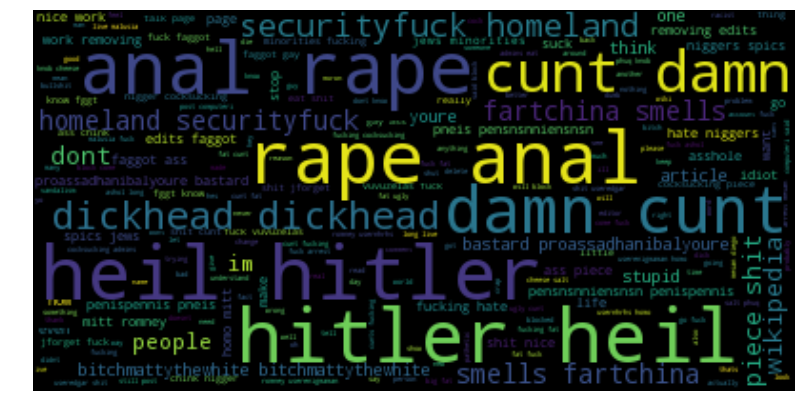

In [70]:
generate_cloud(df[(df.label==1) & (df.pred>0.5)].comment_text_clean)

In [71]:
df[df.comment_text_clean.str.contains('hate u')]

,comment_text_clean,label,pred
13622,i feel i ought to say that i shall no longer a...,0,0.015944


In [75]:
df[(df.label==0) & (df.pred>0.5)].comment_text_clean

40       wow what an incredible douchebag i love the hy...
227      yeah fine httpwwagilitynutcomeateriesmcdhtml e...
286                                   bellend ur a bellend
332      hey dude i d like to know who is in charge of ...
506      leave me alone look m i dont no what your obse...
732      thank you i would just like to thank you for d...
734      be civil hes calling him a sexual predator doe...
784      mate sound like you are jewish gayness is in t...
929      congratulations you just found something that ...
1034     some helpful advice look shithead why the fuck...
1092     see he understands and doesnt want interferenc...
1141     what did i do that was vandalism first of all ...
1281     ill also add that if you do not like the truth...
1496     my actions hi please leave to defend this jerk...
1548     imma cut off ur nutz and send em to ur gf im s...
1697                             no follow the rules loser
1869     french casualty report pansy there are multipl.

In [74]:
train[train.comment_text.str.contains('I promise you')]['comment_text']

23269    The solution without a reference \n\n  //  Y1+...
24603    I'm not prepared for you, I promise you 13 of ...
25627    "\n\nThis ""DavidShankBone"" has been personal...
36554    I only got blocked for spamming. I promise you...
38777    For now, I have lost. But I will come back wit...
53689    Legitimacy\n\nTo me, it has been an honor to b...
55133    Thank You So Much! \n\nToday, I thought I woul...
55336    I promise you the first thing I will do is hav...
57558    You're gonna pay for what you've done, Gregory...
63773    No information in any article was being based ...
66330    Your hobbies... \n\nMum's the word, I won't sa...
79413    "\n\n Editor review \n\nHey Nish, I'm currentl...
86899    "\n\n Please \nI promise you in not a BBHS. Pl...
Name: comment_text, dtype: object

# predictions on the test set

In [224]:
models_list = [(wd_models, test['comment_text_clean']), 
               (char_models, test['comment_text_clean']), 
               (cnt_models, st.replace_entities(test['comment_text']))]

In [ ]:
%%time
predictions = pd.DataFrame(test.id)
loss = 0
for toxicity in classes:
    print(toxicity)
    X_train_stack = np.column_stack([x[0][toxicity].predict_proba(x[1])[:,1] for x in models_list])
    
    predictions[toxicity] = models_stack[toxicity].predict_proba(X_train_stack)[:,1]

In [ ]:
predictions.to_csv(datetime.now().strftime('%Y%m%d%H%M')+'_submission.csv', index=False)